<a href="https://colab.research.google.com/github/YeomSuWoong/Papers-with-Code/blob/main/ESPCN/studynote_ESPCN_gray_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import glob
import cv2
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 구글드라이브레 저장된 이미지 읽어오기
data_list = glob.glob('/content/drive/MyDrive/Colab Notebooks/data/super resolution/train/high_res/*.png')
data_list_val = glob.glob('/content/drive/MyDrive/Colab Notebooks/data/super resolution/test/high_res/*.png')

In [ ]:
# 데이터셋 세팅
class ESPCNDataset(Dataset):
  def __init__(self, paths):
    self.paths = paths

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    path = self.paths[idx]

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, (0,0), 1)
    img = cv2.resize(img, dsize=(64,64))
    img = img.astype(np.float32) / 255.0
    img = img[np.newaxis]

    label_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    label_img = label_img.astype(np.float32) / 255.0
    label_img = label_img[np.newaxis]

    input_sample = torch.tensor(img, dtype=torch.float32)
    label_sample = torch.tensor(label_img, dtype=torch.float32)

    return input_sample, label_sample

In [ ]:
# 데이터셋 생성
train_ds = ESPCNDataset(data_list)
test_ds = ESPCNDataset(data_list_val)

# 데이터로더 생성
train_dl = DataLoader(train_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=1)

In [ ]:
# 데이터 크기 확인
for x, y in train_dl:
  print(x.shape, y.shape)
  break

img = x[0]
target = y[0]
print(img.shape, target.shape)
print(img.dtype)

torch.Size([64, 1, 64, 64]) torch.Size([64, 1, 256, 256])
torch.Size([1, 64, 64]) torch.Size([1, 256, 256])
torch.float32


Text(0.5, 1.0, 'target')

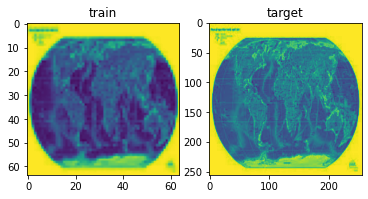

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(to_pil_image(img))
plt.title('train')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(target))
plt.title('target')

In [ ]:
class ESPCN(nn.Module):
  def __init__(self, upscale_factor):
    super(ESPCN, self).__init__()

    self.conv1 = nn.Conv2d(1, 64, (5,5), (1,1), (2,2))
    self.conv2 = nn.Conv2d(64, 64, (3,3), (1,1), (1,1))
    self.conv3 = nn.Conv2d(64, 32, (3,3), (1,1), (1,1))
    self.conv4 = nn.Conv2d(32, 1 * (upscale_factor ** 2), (3,3), (1,1), (1,1))
    self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

  def forward(self, x):
    out = torch.tanh(self.conv1(x))
    out = torch.tanh(self.conv2(out))
    out = torch.tanh(self.conv3(out))
    out = torch.sigmoid(self.pixel_shuffle(self.conv4(out)))
    return out

In [ ]:
# 모델 체크
x = torch.randn(64,1,64,64).to(device)
model = ESPCN(upscale_factor = 4).to(device)
output = model(x)
print(output.shape)

torch.Size([64, 1, 256, 256])


In [ ]:
# 정확도 측정
def psnr(label, outputs, max_val=1.):
  label = label.cpu().detach().numpy()
  outputs = outputs.cpu().detach().numpy()

  img_diff = label - outputs
  rmse = math.sqrt(np.mean((img_diff)**2))

  if rmse == 0: # label 데이터와 일치하는 경우
    return 100
  else:
    psnr = 20 * math.log10(max_val/rmse)
    return psnr

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  start = time.time()
  for epoch in range(1, n_epochs+1):
    loss_train = 0.0
    psnr_train = 0.0

    for _, (image, label) in enumerate(train_loader):
      imgs = image.to(device=device)
      labels = label.to(device=device)

      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      batch_psnr = psnr(labels, outputs)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()
      psnr_train += batch_psnr

    if epoch == 1 or epoch % 10 == 0:
      print('Epoch {}, Training loss {}, Training psnr {}'.format(epoch, loss_train / len(train_loader), psnr_train / int(len(train_ds)/train_loader.batch_size)))

  final_loss = loss_train / len(train_loader)
  final_psnr = psnr_train / int(len(train_ds)/train_loader.batch_size)
  end = time.time()
  print('Total Training time is {} sec'.format(end-start))
  return final_loss, final_psnr

In [ ]:
def validate(model, loss_fn, validation_loader):
  model.eval()
  loss_val = 0.0
  psnr_val = 0.0

  with torch.no_grad():
    for _, (image, label) in enumerate(validation_loader):
      imgs = image.to(device=device)
      labels = label.to(device=device)
      
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      batch_psnr = psnr(labels, outputs)

      loss_val += loss.item()
      psnr_val += batch_psnr

    outputs = outputs.cpu()

  final_loss = loss_val / len(validation_loader)
  final_psnr = psnr_val / int(len(test_ds)/validation_loader.batch_size)
  return final_loss, final_psnr

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [ ]:
training_loop(
    n_epochs = 500,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_dl
)

Epoch 1, Training loss 0.050782399929382584, Training psnr 15.012410145551666
Epoch 10, Training loss 0.007517546880990267, Training psnr 23.37037074631693
Epoch 20, Training loss 0.00519615492190827, Training psnr 25.13595981450232
Epoch 30, Training loss 0.0038589841516857796, Training psnr 26.558957148879536
Epoch 40, Training loss 0.0035917773758145895, Training psnr 26.902107131380625
Epoch 50, Training loss 0.0034230919343165374, Training psnr 27.132963600493746
Epoch 60, Training loss 0.0033304030710661955, Training psnr 27.26449743473554
Epoch 70, Training loss 0.0032723396381532602, Training psnr 27.348820863542294
Epoch 80, Training loss 0.003232324284247377, Training psnr 27.407703737702413
Epoch 90, Training loss 0.003200445684011687, Training psnr 27.454932925982128
Epoch 100, Training loss 0.003176988779821179, Training psnr 27.4899564733163
Epoch 110, Training loss 0.0031500257001343098, Training psnr 27.5308092719269
Epoch 120, Training loss 0.003112835026430813, Traini

(0.0028066226408224215, 28.085747826394957)

In [ ]:
validate(
    model = model,
    loss_fn = loss_fn,
    validation_loader = test_dl
)

(0.00287519110899987, 26.499526461493797)

Text(0.5, 1.0, 'ground_truth')

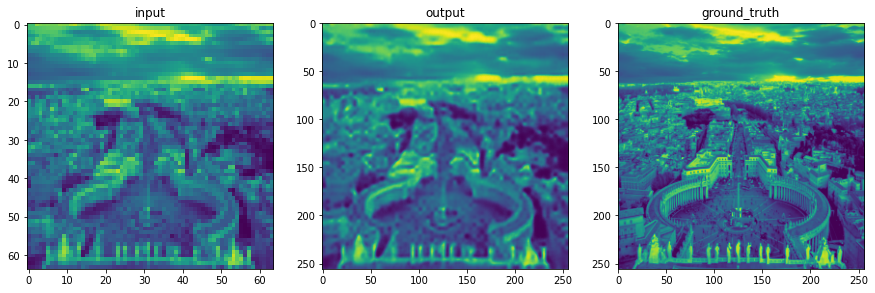

In [ ]:
from torchvision.transforms.functional import to_pil_image
# 이미지 꺼내기
for img, label in test_dl:
    img = img[0]
    label = label[0]
    break

# super-resolution
model.eval()
with torch.no_grad():
    img_ = img.unsqueeze(0)
    img_ = img_.to(device)
    output = model(img_)
    output = output.squeeze(0)

#print(img)
#print(output)
# 시각화
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(to_pil_image(img))
plt.title('input')
plt.subplot(1,3,2)
plt.imshow(to_pil_image(output))
plt.title('output')
plt.subplot(1,3,3)
plt.imshow(to_pil_image(label))
plt.title('ground_truth')